# Sentiment Analyzer Using ULMFit

This notebook demonstrates how to use the [ULMFit model](https://arxiv.org/abs/1801.06146) implemented by `thai2fit` for sentiment analysis. We use a consolidated dataset with 34,607 online reviews including those from [JagerV3](https://github.com/JagerV3/sentiment_analysis_thai). We undersampled the reviews to have roughly 50/50 split.

Our workflow is as follows:

* Perform 85/15 train-validation split (use all data for actual sentiment analyzer)
* Minimal text cleaning and tokenization using `newmm` engine of `pyThaiNLP`
* Get embeddings of Wongnai dataset from all the data available (train and test sets)
* Load pretrained Thai Wikipedia embeddings; for those embeddings which exist only in sentiment dataset, we use the average of Wikipedia embeddings instead
* Train language model based on all the data available on Wongnai dataset
* Replace the top and train the classifier based on the training set by gradual unfreezing

We achieved validation perplexity at 39.86178 and validation accuracy at 89%. FastText benchmark has the performance of 72%.

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import dill as pickle
from collections import Counter
from pathlib import Path
from sklearn.model_selection import train_test_split

from fastai import *
from fastai.text import *
import pythainlp
from pythainlp.ulmfit import *


DATA_PATH='../sent_data/'
RAW_PATH = f'{DATA_PATH}raw/'
MODEL_PATH = f'{DATA_PATH}models/'

## Dataset

The training data consists of 29,415 reviews from unknown number of reviewers relabled by us as positive (`1`) or negative (`0`). We use 85/15 train-validation split. The validation set has 5,192 reviews. No information accuracy is 52.5%. The dataset can be downloded [here](https://www.dropbox.com/s/onrddd8h3hezccn/sent_raw.csv?dl=0).

Data path structure should be
* `sent_data`
    * `raw`: save the file here as `sent_raw.csv`
    * `models`: store models

In [2]:
df = pd.read_csv(f'{RAW_PATH}sent_raw.csv')
df = df.drop('src',1)
df.query('target==1').tail()

,target,text
34526,1,พึ่งไปทานมาเมื่ออาทิตย์ที่แล้ว อร่อยมากเลยค่ะ
34527,1,เมื่อวานไปทานที่the mall บางกะปิ พนักงานน่ารัก...
34528,1,กินที่บางกะปิมา พนักงานใจดีทุกคนเลย
34529,1,ดีมากๆเรย สาขาเซนแจ้งพนักงานเฟรนลี่ทุกคนเรย
34530,1,อาหารอร่อยมีให้เลือกเยอะมาก


In [3]:
df.query('target==0').tail()

,target,text
34602,0,เอาของเก่ามาขาย ใช้น้ำมันเก่ามาทอด ขายให้ลูกค้...
34603,0,แอดมินเพจทำงานแย่มากนะคะ ไม่อินบ๊อกซ์แจ้งผู้โช...
34604,0,ไปซื้อพิซซ่า สาขาถ.จันทร์ สั่งพิซซ่ามาสองกล่อง...
34605,0,พนักงานน่ายังกะส้นตีน สงสัยทะเลาะกับผัวมา พูดอ...
34606,0,รับปรุงด่วนเลยครับ เรื่องเวลาเสริฟให้ลูกค้า นา...


In [4]:
print(df.shape)
cnt = Counter(df['target'])
cnt

(34607, 2)


Counter({1: 16451, 0: 18156})

In [5]:
#baseline
cnt.most_common(1)[0][1] / df.shape[0]

0.5246337446181408

In [6]:
#train/validation/train_language_model split for fasttext
df_trn, df_val = train_test_split(df, test_size = 0.15, random_state = 1412)

df.to_csv(f'{DATA_PATH}df_all.csv', header=False, index=False)
df_trn.to_csv(f'{DATA_PATH}train.csv', header=False, index=False)
df_val.to_csv(f'{DATA_PATH}valid.csv', header=False, index=False)

## Language Modeling

### Text Processing

We first determine the vocab for the reviews, then train a language model based on our training set. We perform the following  text processing:

* Fix html tags to plain texts
* Lowercase all English words and if a word is written in all caps, we put it in a lower case and add `xxup` before
* Repetitive characters: Thai usually emphasizes adjectives by repeating the last character such as `อร่อยมากกกกกกก` to `อร่อยมาก xxrep 7 ` so that the word still retains its original form. 
* Normalize character order: for instance `นำ้` to `น้ำ`
* Add spaces around / and #
* Remove multiple spaces and newlines
* Remove empty brackets of all types (`([{`) which might result from cleaning up
* `pyThaiNLP`'s `newmm` word tokenizer with frozen dictionary (`engine ='ulmfit'`)  is used to tokenize the texts.

In [9]:
# tt = Tokenizer(tok_func = ThaiTokenizer, lang = 'th', rules = thai_rules)
# data_lm = TextLMDataBunch.from_csv(path = Path(DATA_PATH),csv_name='df_all.csv',valid_pct=0.1,
#                                   tokenizer=tt, vocab = None)
# data_lm.save('sent_lm')

In [8]:
data_lm = TextLMDataBunch.load(DATA_PATH,'sent_lm',bs=64)

In [9]:
len(data_lm.vocab.itos)

11123

In [10]:
len(data_lm.valid_ds), len(data_lm.train_ds)

(3461, 31145)

### Load Pretrained Language Model

Instead of starting from random weights, we import the language model pretrained on Wikipedia (see `pretrained_wiki.ipynb`). For words that appear only in the Wongnai dataset but not Wikipedia, we start with the average of all embeddings instead.

In [11]:
#get pretrained models via pythainlp
model_path,itos_path = pythainlp.ulmfit._THWIKI_LSTM

wgts = torch.load(f'{model_path}.pth', map_location=lambda storage, loc: storage)
itos_lstm = pickle.load(open(f'{itos_path}.pkl','rb'))
wgts = merge_wgts(300, wgts, itos_lstm, data_lm.vocab.itos)
wgts['0.encoder.weight'].shape, len(wgts.keys())

(torch.Size([11123, 300]), 18)

### Train Domain-Specific Language Model

In [22]:
#heuristic reference from imdb_scripts
learn = language_model_learner(data_lm, bptt = 70, emb_sz = 300, nh = 1150, nl = 3,
                                  drop_mult = 0.7, bias = False, qrnn = False, 
                                  alpha=2, beta = 1,
                                  pretrained_fnames = None)
learn.metrics = [accuracy]
learn.opt_func = partial(optim.Adam, betas=(0.8, 0.99))
learn.wd = 1e-7
#VERY IMPORTANT TO LOAD PRETRAINED WEIGHTS
learn.model.load_state_dict(wgts)

If you want to use the QRNN version use the following `language_model_learner` instead.

In [13]:
# learn = language_model_learner(data_lm, bptt = 70, emb_sz = 400, nh = 1550, nl = 3,
#                                   drop_mult = 0.3, bias = True, qrnn = True, 
#                                   alpha=2, beta = 1,
#                                   pretrained_fnames = pythainlp.ulmfit._THWIKI_QRNN)
# learn.metrics = [accuracy]
# learn.opt_func = partial(optim.Adam, betas=(0.8, 0.99))
# learn.wd = 1e-7

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


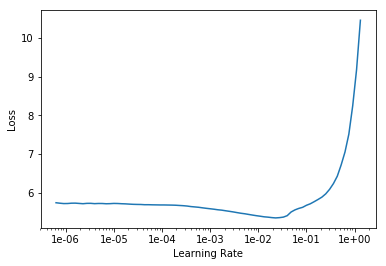

In [18]:
learn.lr_find()
learn.recorder.plot()

In [23]:
#optimal learning rate and wd
lr = 0.05 / 10
wd = 1e-7
learn.freeze()

In [24]:
#train frozen to warm up
learn.fit_one_cycle(cyc_len = 1, 
                    max_lr= lr, #learning rate
                    div_factor=20, #factor to discount from max
                    moms = (0.8, 0.7), #momentums
                    pct_start = 0.3, #where the peak is at 
                    wd = wd #weight decay
                   ) 

Total time: 01:49
epoch  train_loss  valid_loss  accuracy
1      4.458854    4.235346    0.314211  (01:49)



In [25]:
#train unfrozen
learn.unfreeze()
learn.fit_one_cycle(cyc_len = 3, 
                    max_lr= lr, #learning rate
                    div_factor=20, #factor to discount from max
                    moms = (0.8, 0.7), #momentums
                    pct_start = 0.3, #where the peak is at 
                    wd = wd #weight decay
                   ) 

Total time: 07:00
epoch  train_loss  valid_loss  accuracy
1      4.118326    4.012748    0.332127  (02:20)
2      3.875142    3.810460    0.347802  (02:19)
3      3.633786    3.742740    0.354012  (02:20)



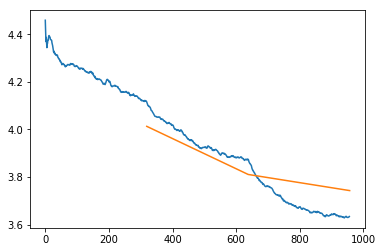

In [26]:
learn.recorder.plot_losses()
learn.save('sent_lm_lstm')
learn.save_encoder('sent_enc_lstm')

### Eye-balling Finetuned Language Model

In order to get a sense of how 'good' our finetuned language model is at understanding domain-specific texts, we can use the model to try predicting the next word and sentence.

In [27]:
predict_word('ร้านนี้ดี',learn,data_lm, topk =10)

[' ', 'นะ', 'ครับ', 'ค่ะ', 'ที่สุด', 'เลย', 'อยู่', 'ที่', 'มาก', 'คะ']

In [28]:
''.join(predict_sentence('ร้านนี้',learn,data_lm, nb_words = 15))

'อยู่ในซอยสุขุมวิท 50 (ซอย) อยู่ฝั่งตรงข้ามกับ'

## Classification

With the language model trained on the dataset, we use its embeddings to initialize the sentiment analyzer. We train the classifier using discriminative learning rates, slanted triangular learning rates, gradual unfreezing and a few other tricks detailed in the [ULMFit paper](https://arxiv.org/abs/1801.06146). We have found that training only the last two layers of the model seems to be the right balance for this dataset.

### Data Bunch

Create another data bunch this time for classification, using the same vocab as the our finetuned language model.

In [87]:
# tt = Tokenizer(tok_func = ThaiTokenizer, lang = 'th', rules = thai_rules)
# data_clas = TextClasDataBunch.from_df(path=Path(DATA_PATH), train_df = df_trn, valid_df = df_val, 
#                                        tokenizer=tt, vocab=data_lm.vocab)
# data_clas.save('sent_clas')

In [92]:
data_clas = TextClasDataBunch.load(DATA_PATH,'sent_clas',bs=64)

In [93]:
data_clas.train_ds.y.classes

[0, 1]

In [94]:
Counter([int(i) for i in data_clas.train_ds.y])

Counter({0: 15460, 1: 13955})

In [95]:
Counter([int(i) for i in data_clas.valid_ds.y])

Counter({0: 2696, 1: 2496})

In [96]:
#check if using right vocab
len(data_clas.vocab.itos)==len(data_lm.vocab.itos)

True

In [97]:
len(data_clas.vocab.itos)

11123

### Model

We create a text classifier by combining our finetuned encoder with a linear model. For larger datasets use lower `drop_mult` for more regularization, and vice versa.

In [118]:
#heuristic reference from imdb_scripts
learn = text_classifier_learner(data_clas, bptt = 70, emb_sz = 300, nh = 1150, nl = 3,
                                  drop_mult = 0.5, clip =25.,
                                  alpha=2, beta = 1)
learn.metrics = [accuracy]
learn.opt_func = partial(optim.Adam, betas=(0.7, 0.99))
#VERY IMPORTANT TO LOAD ENCODER
learn.load_encoder('sent_enc_lstm')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


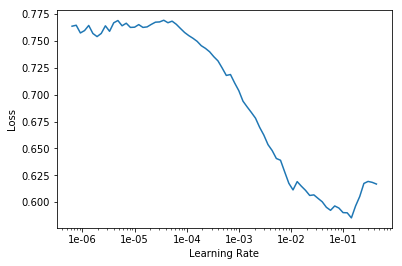

In [109]:
#select max lr
learn.lr_find()
learn.recorder.plot()

### Training

We gradually unfreeze from the last layer through to the whole model with discriminative learning rates, higher learning rates for the later layers. We usually pick the max learning rate as the point where the decrease in loss is steepest and decreases it as we train earlier layers.

In [110]:
#frozen
lr = 0.01
learn.freeze_to(-1)
learn.fit_one_cycle(cyc_len = 5, 
                    max_lr= slice(lr/(2.6**4),lr), #learning rate
                    div_factor=10, #factor to discount from max
                    moms = (0.8, 0.7), #momentums
                    pct_start = 0.1, #where the peak is at 
                    wd = 1e-7
                   ) 
learn.save('frozen')

Total time: 10:35
epoch  train_loss  valid_loss  accuracy
1      0.416545    0.345185    0.861903  (02:15)
2      0.392177    0.336243    0.864599  (01:51)
3      0.378507    0.327924    0.864214  (01:58)
4      0.378574    0.320207    0.873844  (02:14)
5      0.388053    0.320264    0.874230  (02:15)



In [111]:
#gradual unfreeze 1
learn.load('frozen')
lr = 0.01
learn.freeze_to(-2)
learn.fit_one_cycle(cyc_len = 5, 
                    max_lr= slice(lr/(2.6**4),lr), #learning rate
                    div_factor=10, #factor to discount from max
                    moms = (0.8, 0.7), #momentums
                    pct_start = 0.1, #where the peak is at 
                    wd = 1e-7
                   ) 
learn.save('unfreeze_1')

Total time: 12:53
epoch  train_loss  valid_loss  accuracy
1      0.311486    0.305556    0.883282  (02:27)
2      0.320408    0.317023    0.879623  (02:39)
3      0.289731    0.285402    0.893297  (02:33)
4      0.273263    0.277213    0.892720  (02:42)
5      0.223639    0.281888    0.894260  (02:31)



In [119]:
#gradual unfreeze 2
learn.load('unfreeze_1')
lr = 0.01/2
learn.freeze_to(-3)
learn.fit_one_cycle(cyc_len = 3, 
                    max_lr= slice(lr/(2.6**4),lr), #learning rate
                    div_factor=10, #factor to discount from max
                    moms = (0.8, 0.7), #momentums
                    pct_start = 0.1, #where the peak is at 
                    wd = 1e-7
                   ) 
learn.save('unfreeze_2')

Total time: 11:36
epoch  train_loss  valid_loss  accuracy
1      0.256176    0.284819    0.892527  (03:56)
2      0.231310    0.282900    0.890216  (04:09)
3      0.183823    0.298039    0.893683  (03:29)



In [103]:
#unfrozen
learn.load('unfreeze_2')
learn.unfreeze()
lr = 0.01/4
learn.fit_one_cycle(cyc_len = 5, 
                    max_lr= slice(lr/(2.6**4),lr), #learning rate
                    div_factor=10, #factor to discount from max
                    moms = (0.8, 0.7), #momentums
                    pct_start = 0.1, #where the peak is at 
                    wd = 1e-7
                   ) 
learn.save('unfrozen')

Total time: 15:20
epoch  train_loss  valid_loss  accuracy
1      0.303518    0.289784    0.891949  (05:12)
2      0.279527    0.281602    0.895416  (05:34)
3      0.291195    0.291165    0.887904  (04:33)



## Validation Performance

`unfreeze_1` seems to have the best validation performance so we will use it for the validation.

In [120]:
learn.load('unfreeze_1')
#get validation performance
probs,y= learn.get_preds()
probs = probs.numpy()
y = y.numpy()
preds = np.argmax(probs,1)

In [121]:
data_clas.y.classes

[0, 1]

In [122]:
#index to class
y = np.array([data_clas.train_ds.y.classes[i] for i in y])
preds = np.array([data_clas.train_ds.y.classes[i] for i in preds])

In [123]:
#plotting
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [124]:
Counter(y)

Counter({1: 2496, 0: 2696})

Baseline Micro F1: 0.5192604006163328
Micro F1: 0.8942604006163328
Confusion matrix, without normalization
[[2405  291]
 [ 258 2238]]


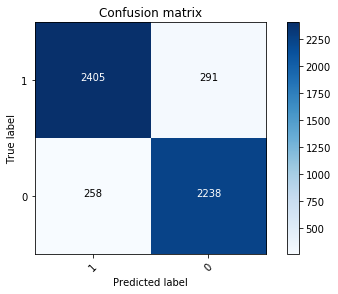

In [127]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score

most_frequent = np.array([0]*len(preds))
print(f'Baseline Micro F1: {fbeta_score(y,most_frequent,1,average="micro")}')
print(f'Micro F1: {fbeta_score(y,preds,1,average="micro")}')
cm = confusion_matrix(y,preds)
plot_confusion_matrix(cm,classes=[1,0])

## Benchmark with FastText

We used [fastText](https://github.com/facebookresearch/fastText)'s own [pretrained embeddings](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md) and a relatively "default" settings in order to benchmark our results. This gave us the accuracy of 71%.

### Data Preparation

In [2]:
df_trn = pd.read_csv(f'{DATA_PATH}train.csv',header=None)
df_val = pd.read_csv(f'{DATA_PATH}valid.csv',header=None)

In [3]:
train_set = []
for i in range(df_trn.shape[0]):
    label = df_trn.iloc[i,0]
    line = df_trn.iloc[i,1].replace('\n', ' ')
    train_set.append(f'__label__{label} {line}')
train_doc = '\n'.join(train_set)
with open(f'{DATA_PATH}train.txt','w') as f:
    f.write(train_doc)

In [4]:
valid_set = []
for i in range(df_val.shape[0]):
    label = df_val.iloc[i,0]
    line = df_val.iloc[i,1].replace('\n', ' ')
    valid_set.append(f'__label__{label} {line}')
valid_doc = '\n'.join(valid_set)
with open(f'{DATA_PATH}valid.txt','w') as f:
    f.write(valid_doc)

### Train fastText

In [ ]:
!/home/ubuntu/theFastText/fastText-0.1.0/fasttext supervised -input '{DATA_PATH}train.txt' -pretrainedVectors '{MODEL_PATH}wiki.th.vec' -epoch 10 -dim 300 -wordNgrams 2 -output '{MODEL_PATH}fasttext_model'

Read 0M words
Number of words:  163451
Number of labels: 2
Progress: 100.0%  words/sec/thread: 572869  lr: 0.000000  loss: 0.212743  eta: 0h0m 


In [6]:
!/home/ubuntu/theFastText/fastText-0.1.0/fasttext test '{MODEL_PATH}fasttext_model.bin' '{DATA_PATH}valid.txt'

N	5192
P@1	0.716
R@1	0.716
Number of examples: 5192
